<a href="https://colab.research.google.com/github/AzusaFighting/DVdata/blob/main/labex7_seq2seq.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

First we import libraries and set the random seed:

In [1]:
from torchvision.datasets.utils import download_url
from torch.utils.data import Dataset, DataLoader, random_split
from torch.nn.utils.rnn import pad_sequence
from torch import nn
from torch.nn import functional as F
from torch import optim
from tqdm.autonotebook import tqdm
from textwrap import wrap
import random
import sys
import io
import random
import numpy as np
import torch

torch.manual_seed(0)

The following block defines a dataset object which parses our data file and performs numericalisation of the sequence data:

In [2]:
class CodeDataset(Dataset):
    def __init__(self):
        download_url('https://github.com/ecs-vlc/COMP6248/raw/master/exercises/lab7/dataset.txt', '.', 'dataset.txt', None)
        with io.open('dataset.txt', 'r') as f:
            self.data = f.readlines()

        self.PAD='_'
        self.SOS='^'
        self.EOS='$'
        self.PAD_IDX=0

        # construct the vocabularies to numericalise the data
        self.alphabet = "*".join(self.PAD+self.SOS+self.EOS+"abcdefghijklmnopqrstuvwxyz ").split('*')

        self.alphabet_indices = dict((c, i) for i, c in enumerate(self.alphabet))
        self.indices_alphabet = dict((i, c) for i, c in enumerate(self.alphabet))

        self.morsebet = self.PAD+self.SOS+self.EOS+'.- /'
        self.morse_indices = dict((c, i) for i, c in enumerate(self.morsebet))
        self.indices_morse = dict((i, c) for i, c in enumerate(self.morsebet))

    def encode_alpha(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.alphabet_indices[char]

        return x

    def decode_alpha(self, ten, skip_tok=False):
        s = ''
        ten = ten.view(-1)
        for v in ten.view(-1):
            if not skip_tok:
                s += self.indices_alphabet[v.item()]
            elif v>2:
                s += self.indices_alphabet[v.item()]
        return s

    def encode_morse(self, inp):
        x = torch.zeros(len(inp), dtype=torch.long)
        for t, char in enumerate(inp):
            x[t] = self.morse_indices[char]

        return x

    def decode_morse(self, ten):
        s = ''
        for v in ten:
          s += self.indices_morse[v]
        return s

    def __len__(self):
        return len(self.data)

    def __getitem__(self, i):
        inp, out = self.data[i].strip().split('|')
        x = self.encode_morse(inp)
        y = self.encode_alpha(out[::-1])
        return x, y


# This will be used to automatically pad all batch items to the same length
def pad_collate(batch): 
    data = [item[0] for item in batch]
    data = pad_sequence(data)
    targets = [item[1] for item in batch]
    targets = pad_sequence(targets)
    return [data, targets]

# Load the data and split randomly into training and val subsets
ds = CodeDataset()
tr, va = random_split(ds, [len(ds) - len(ds)//3, len(ds)//3])
trainloader = DataLoader(tr, batch_size=1024, shuffle=True, collate_fn=pad_collate)
valloader = DataLoader(va, batch_size=1024, shuffle=False, collate_fn=pad_collate)

  0%|          | 0/5482800 [00:00<?, ?it/s]

We next define the model architecture, which is made up of an encoder, a decoder and the Seq2Seq class which ties everything together:

In [17]:
class Encoder(nn.Module):
    def __init__(self, input_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(input_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        
    def forward(self, src):
        embedded = self.embedding(src)
        _, (hidden, cell) = self.rnn(embedded)
        return hidden, cell

class Decoder(nn.Module):
    def __init__(self, output_dim, emb_dim, hid_dim):
        super().__init__()
        
        self.output_dim = output_dim
        self.hid_dim = hid_dim
        self.embedding = nn.Embedding(output_dim, emb_dim)
        self.rnn = nn.LSTM(emb_dim, hid_dim)
        self.fc_out = nn.Linear(hid_dim, output_dim)
        
    def forward(self, input, hidden, cell):
        input = input.unsqueeze(0)
        embedded = self.embedding(input)
        output, (hidden, cell) = self.rnn(embedded, (hidden, cell))        
        prediction = self.fc_out(output.squeeze(0))
        return prediction, hidden, cell


class Seq2Seq(nn.Module):
    def __init__(self, encoder, decoder):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        
    def forward(self, src, trg=None, teacher_forcing_ratio = 0.5, maxlen=5, padding_idx=0):
        batch_size = src.shape[1]
        trg_len = trg.shape[0] if trg is not None else maxlen
        trg_vocab_size = self.decoder.output_dim

        outputs = torch.zeros(trg_len, batch_size, trg_vocab_size).to(src.device)
        hidden, cell = self.encoder(src)

        input = torch.ones(batch_size, dtype=torch.long, device=src.device) * padding_idx
        for t in range(1, trg_len):
            output, hidden, cell = self.decoder(input, hidden, cell)
            outputs[t] = output
            
            teacher_force = random.random() < teacher_forcing_ratio
            top1 = output.argmax(1) 
            input = trg[t] if teacher_force and trg is not None else top1
        
        return outputs


INPUT_DIM = len(ds.morsebet)
OUTPUT_DIM = len(ds.alphabet)
ENC_EMB_DIM = 128
DEC_EMB_DIM = 128
HID_DIM = 256

enc = Encoder(INPUT_DIM, ENC_EMB_DIM, HID_DIM)
dec = Decoder(OUTPUT_DIM, DEC_EMB_DIM, HID_DIM)
model = Seq2Seq(enc, dec).cuda()

Finally, we can train and evaluate the model:

In [18]:
crit = nn.CrossEntropyLoss(ignore_index=ds.PAD_IDX)
opt = optim.Adam(model.parameters(), lr=1e-3)
train_loss = []
val_loss = []

for e in range(10):
    model.train()

    with tqdm(total=len(trainloader), desc='train') as t:
        epoch_loss = 0
        for i, (x, y) in enumerate(trainloader):
            x = x.cuda()
            y = y.cuda()

            opt.zero_grad()
            pred = model(x, y, padding_idx=ds.PAD_IDX)

            pred_dim = pred.shape[-1]
            pred = pred[1:].view(-1, pred_dim)
            y = y[1:].view(-1)

            loss = crit(pred, y)
            loss.backward()
            opt.step()

            epoch_loss = (epoch_loss*i + loss.item()) / (i+1)

            t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
            t.update()
    train_loss.append(epoch_loss)

    model.eval()
    with tqdm(total=len(valloader), desc='val') as t:
        with torch.no_grad():
            epoch_loss = 0
            for i, (x, y) in enumerate(valloader):
                x = x.cuda()
                y = y.cuda()

                pred = model(x, y, teacher_forcing_ratio=0, padding_idx=ds.PAD_IDX)

                pred_dim = pred.shape[-1]
                pred = pred[1:].view(-1, pred_dim)
                y = y[1:].view(-1)

                loss = crit(pred, y)
                epoch_loss = (epoch_loss*i + loss.item()) / (i+1)

                t.set_postfix(loss='{:05.3f}'.format(epoch_loss))
                t.update()

    val_loss.append(epoch_loss)

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

train:   0%|          | 0/163 [00:00<?, ?it/s]

val:   0%|          | 0/82 [00:00<?, ?it/s]

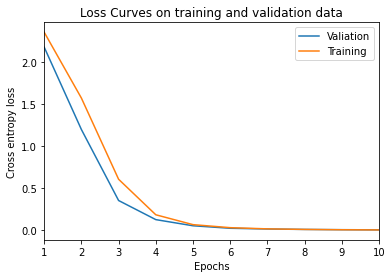

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<Figure size 432x288 with 0 Axes>

In [20]:
import matplotlib.pyplot as plt
import numpy as np
from google.colab import files

epochs = np.linspace(1,10,10)
plt.plot(epochs,val_loss, label='Valiation')
plt.plot(epochs,train_loss, label='Training')
plt.xlim(1,10)
plt.xlabel('Epochs')
plt.ylabel('Cross entropy loss')
plt.legend()
plt.title('Loss Curves on training and validation data')
plt.show()
plt.savefig('lab5_3_acc_loss.png')
files.download('lab5_3_acc_loss.png')

In [12]:
def decode(code: str):
  out = ' '
  for chunk in code.split(' '):
    num = ds.encode_morse('^ ' + chunk + ' $').unsqueeze(1)
    pred = model(num.cuda(), maxlen=2)
    pred = pred[1:].view(-1, pred_dim).argmax(-1)
    out += ds.decode_alpha(pred.cpu())[::-1]
  return out

In [14]:
print(decode(".- -. ... .-- . .-. / - .... . / ..-. --- .-.. .-.. --- .-- .. -. --."))
print("  *" + decode(".-- .... -.-- / .. ... / - .... . / --- .-. -.. . .-. / --- ..-. / -.... . / --- ..- - .--. ..- - / .-. . ...- . .-. ... . -.."))
print("  *" + decode(".-- .... .- - / .. ... / - .... . / .--. --- .. -. - / --- ..-. / - ..- -.-. .... . .-. / ..-. --- .-. -.-. .. -. --."))

 answer the following
  * why is the order of be output reversed
  * what is the point of tucher forcing


In [ ]:
print("b", decode("-..."))
print("q", decode("--.-"))

# Longer letters use longer sequences, less in the training set
# https://towardsdatascience.com/cracking-morse-code-with-rnns-e5883355a6f3

b  b
q  y
